This code generates the true precision base graph that is used to sample Gaussian random noise from. It alternates between slow and quick changing noise conditions for both high and low precision.

In [1139]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import random, pickle
import resampy
from scipy.stats import gamma, t, norm
from scipy.special import gamma as g
from scipy.special import gammaln

Side note: the relationship between SNR and precision:

SNR = $10 \times \text{log}_{10}(\frac{1}{var})$ (dB) = $10 \times \text{log}_{10}(\gamma)$, where $\gamma$ is the precision.

$\gamma = 10^{(\frac{SNR}{10})}$ (precision) or 
$var = \sigma^2 = 10^{(\frac{-SNR}{10})}$ (variance) or
$\sigma = 10^{(\frac{-SNR}{20})}$ (standard deviation)

See Olivier for calculating EbNo instead of SNR:

$\frac{E_b}{N_o} = \frac{a^2}{2R\sigma^2}$, where $a$ is the signal amplitude and $R$ is the code rate.

In [1245]:
def studentst(x, alpha, beta, mu):
    p = 2 * alpha      # this is degrees of freedom
    lam = alpha / beta # this is the Gamma mean
    return (np.exp(gammaln((p + 1) / 2) - gammaln(p / 2))) * np.sqrt((lam / (np.pi * p))) * (1 / ((1 + ((lam / p) * (x - mu)**2)))**((p + 1) / 2))


5.0 16.666666666666668


<IPython.core.display.Javascript object>


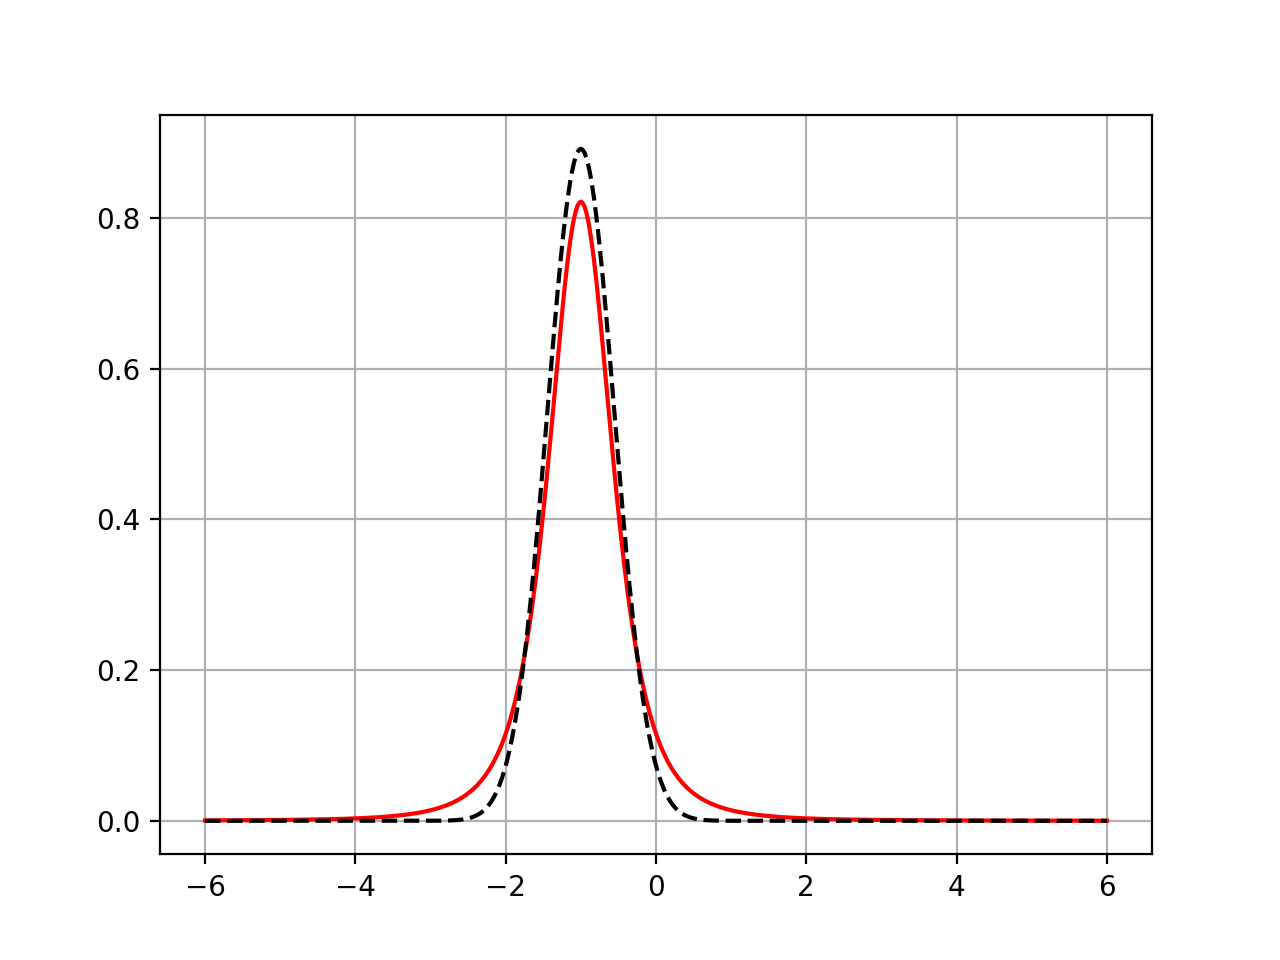

In [1246]:
alpha = 1.5 # shape
beta = 0.3   # rate or scale=1/rate (groot = meer variansie)

mean = alpha / beta
var = alpha / (beta)**2

print(mean, var)

mu = -1

x = np.linspace(-6, 6, 500)
# plt.plot(x, t.pdf(x, loc=0, df=5, scale=1))
plt.plot(x, t.pdf(x, loc=mu, df=alpha*2, scale=np.sqrt(1/(alpha/beta))), alpha=0.5)

# plt.plot(x, studentst(x, alpha, beta, mu), color='blue', linestyle='--')
# plt.plot(x, studentst2(x, alpha, beta, mu), color='red', linestyle='--')
plt.plot(x, studentst(x, alpha, beta, mu), color='red', linestyle='-')

# plt.plot(x, y2, color='blue')
# plt.plot(x, t.pdf(x, loc=-1, df=alpha, scale=beta), color='black')
plt.plot(x, norm.pdf(x, loc=mu, scale=np.sqrt(1/mean)), color='black', linestyle='--')
plt.grid()
plt.show()

5.0 16.666666666666668


<IPython.core.display.Javascript object>


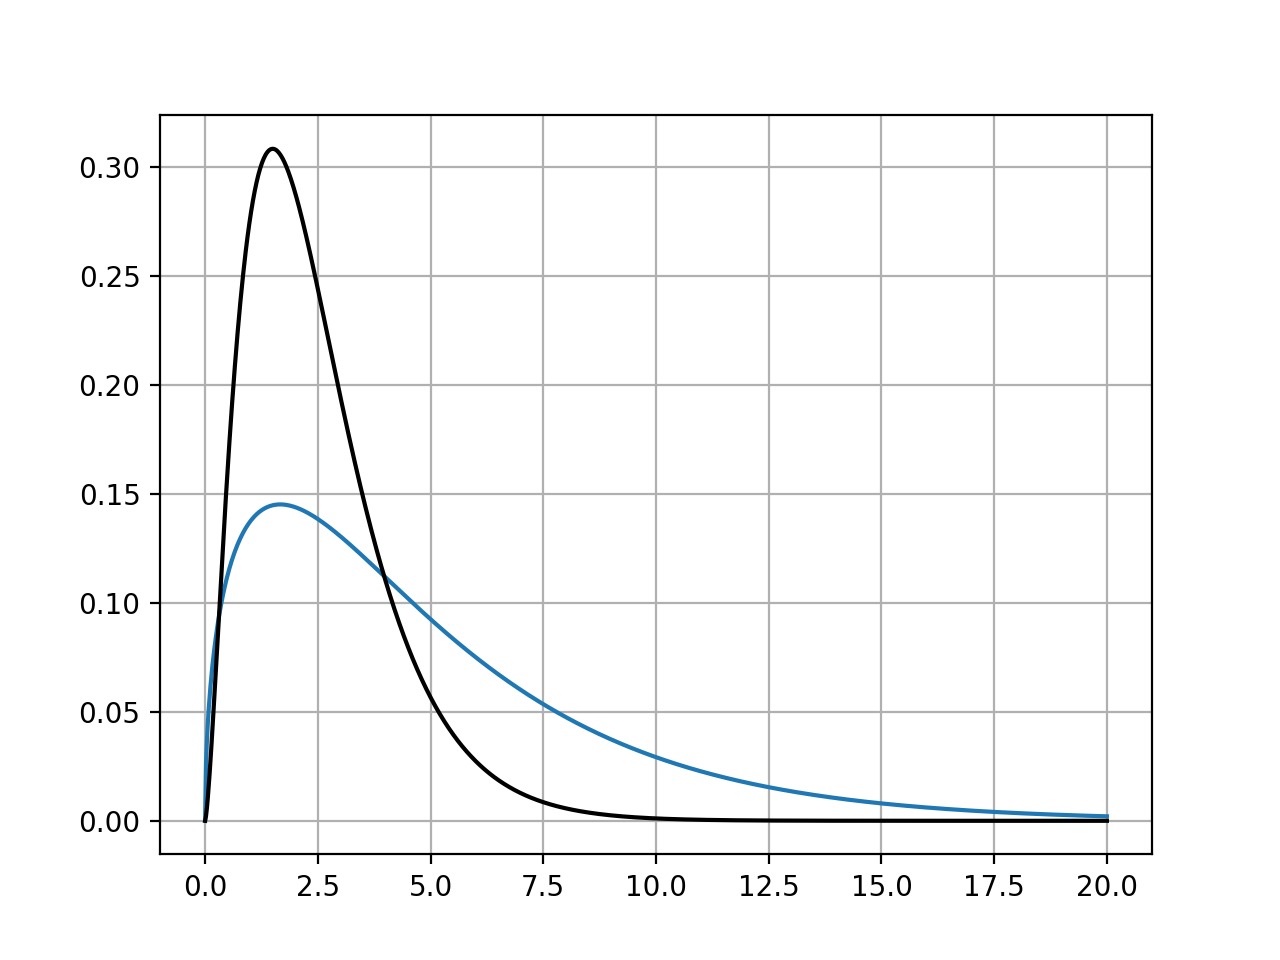

In [659]:
alpha = 1.5 # shape
beta = 0.3   # rate or scale=1/rate

mean = alpha / beta
var = alpha / (beta)**2

print(mean, var)

x = np.linspace(0, 20, 1000)
plt.plot(x, gamma.pdf(x, a=alpha, scale=1/beta))
plt.plot(x, gamma.pdf(x, a=2.5, scale=1/1), color='black')
plt.grid()
plt.show()

In [51]:
# data = []

# for n in range(4):
#     m = np.random.choice([2, 2.1])
#     var = 0.01
#     beta = (m / var)   # rate or scale=1/rate
#     alpha = (m * beta) # shape
#     for i in range(1000):
#         x = np.random.gamma(alpha, 1/beta, 1)[0]
#         data.append(x)

# plt.plot(data)
# plt.grid()
# plt.show()

In [676]:
data = list(np.repeat(5, 5000)) + \
       list(np.repeat(8.5, 5000)) + \
       list(np.repeat(4, 5000)) + \
       list(np.repeat(1.1, 5000)) + \
       list(np.repeat(3, 5000)) + \
       list(np.repeat(5, 5000))

In [983]:
beta = 150   # rate or scale=1/rate
alpha = 2000 # shape
# a = 10000

data = []

for i in range(60000):
    a = 20000
    data.append([alpha, beta, alpha / beta])
    
    if (i % 1) == 0:
        x = np.random.gamma(alpha, 1/beta, 1)[0]
        beta_new = a / x 
        beta = beta_new
        alpha = a
    
    if (i % 20000) == 0:
        a = 100000
        for j in range(20000):
    
            data.append([alpha, beta, alpha / beta])
            
            if (j % 100) == 0:
                x = np.random.gamma(alpha, 1/beta, 1)[0]
                beta_new = a / x 
                beta = beta_new
                alpha = a

In [984]:
test = 10*np.log10([i[2] for i in data])

<IPython.core.display.Javascript object>


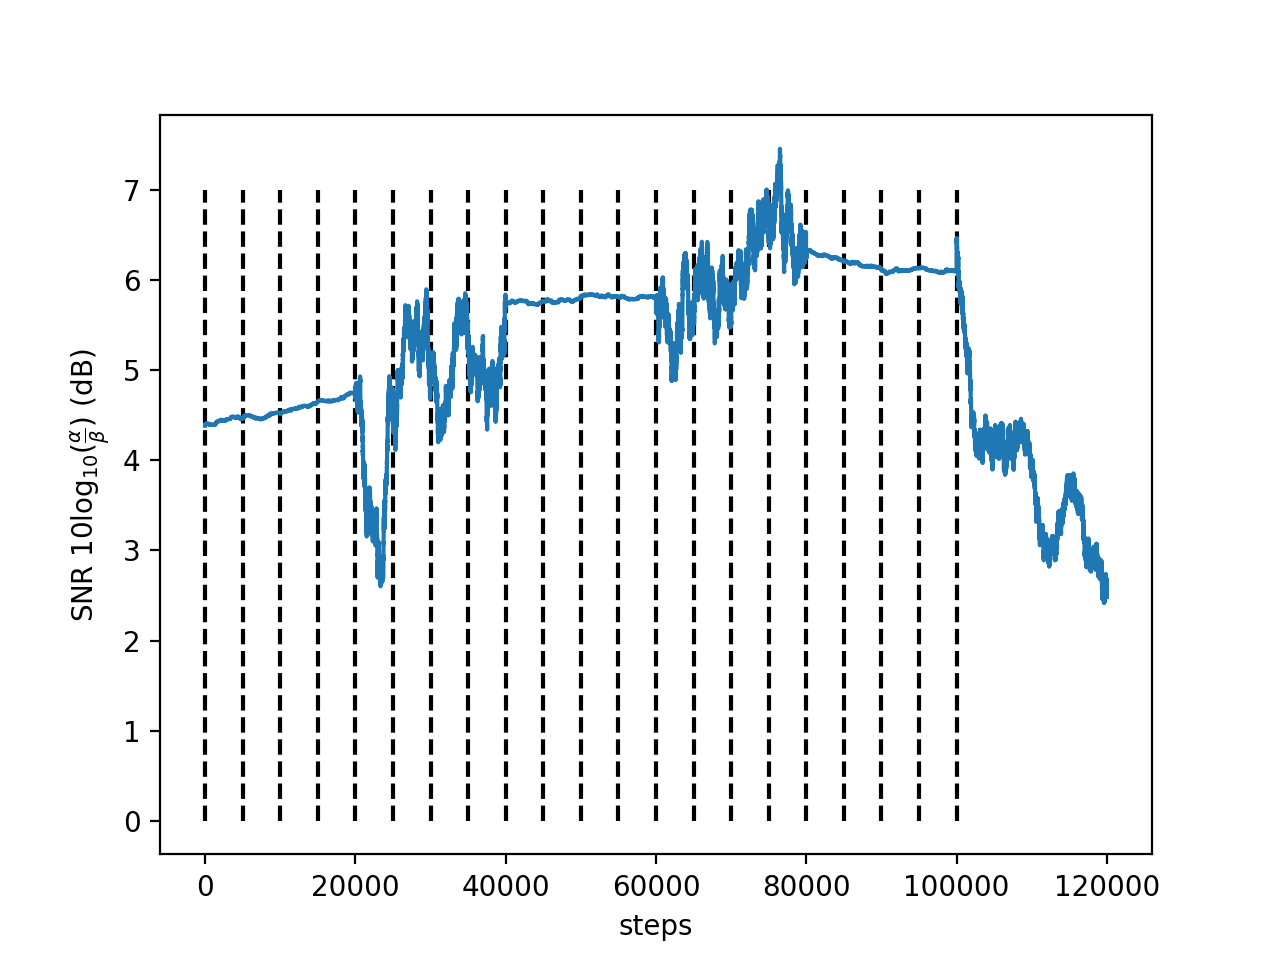

In [1018]:
plt.plot(test, label='Gamma mean')
plt.vlines(np.arange(0, 105000, 5000), 0, 7, linestyle='--')
plt.xlabel("steps")
plt.ylabel(r"SNR $10 \log_{10}(\frac{\alpha}{\beta})$ (dB)")
plt.show()

In [1019]:
# samples = []
# params = []
# alpha = 100000
# for i in noise:
#     beta = (alpha / i)
#     samples.append(np.random.gamma(alpha, 1/beta, 1)[0])
#     params.append([alpha, beta, alpha/beta])

In [1030]:
noise = (10)**(test/10)
samples = []
params = []
for i in range(6):
    if i % 2 == 0:
        alpha = 1000000
        beta = (alpha / noise[i*20000:(i+1)*20000])
        for b in beta:
            samples.append(np.random.gamma(alpha, 1/b, 1)[0])
            params.append([alpha, b, alpha/b])
    else:
        alpha = 100
        beta = (alpha / np.array(noise[i*20000:(i+1)*20000]))
        for b in beta:
            samples.append(np.random.gamma(alpha, 1/b, 1)[0])
            params.append([alpha, b, alpha/b])

In [1031]:
samples = 10*np.log10(samples)

In [1032]:
true_means = [i[2] for i in params]

In [1033]:
true_means = 10*np.log10(true_means)

In [1034]:
true_means.shape, samples.shape

((120000,), (120000,))

<IPython.core.display.Javascript object>


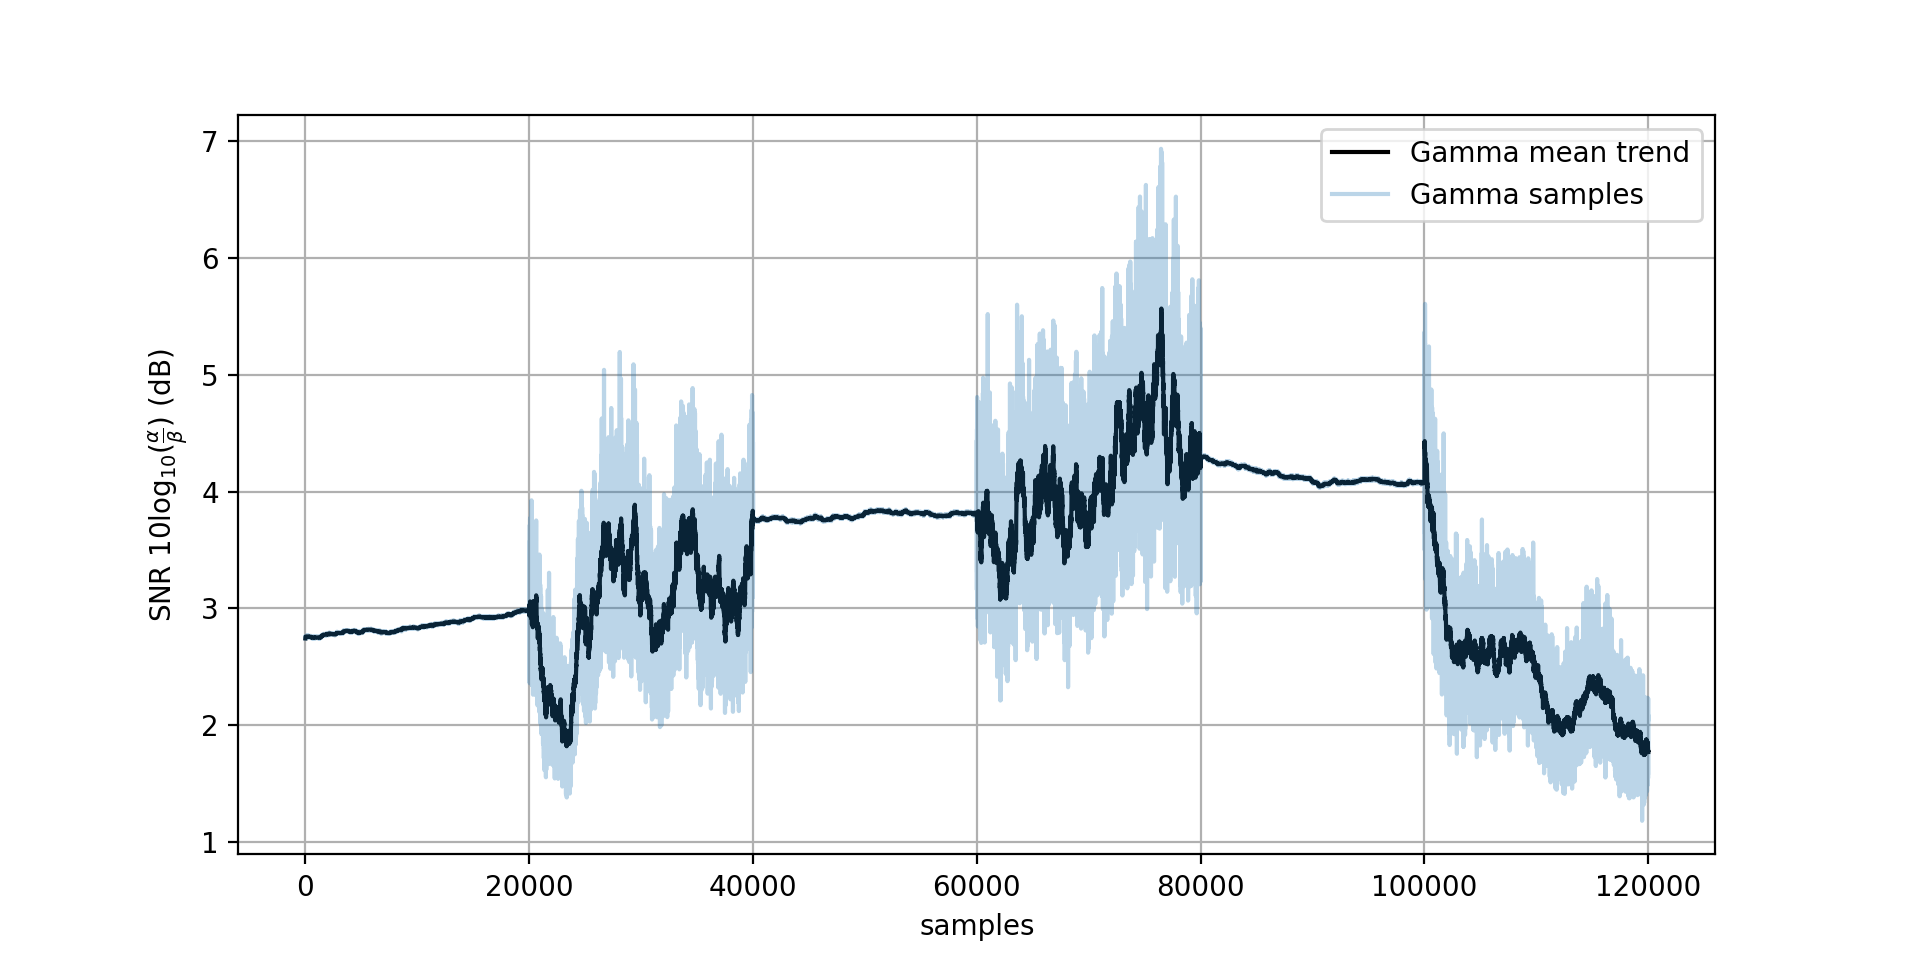

In [1043]:
# plt.plot(test, label='Gamma mean')
plt.plot(true_means, label='Gamma mean trend', color='black')
plt.plot(samples, label='Gamma samples', alpha=0.3)
# plt.vlines(np.arange(0, 105000, 5000), 0, 7, linestyle='--')
plt.xlabel("samples")
plt.ylabel(r"SNR $10 \log_{10}(\frac{\alpha}{\beta})$ (dB)")
plt.legend()
plt.show()

In [1036]:
true_means = (10)**(true_means/10)
samples = (10)**(samples/10)
data = {'samples': samples, 'true_means': true_means}
df = pd.DataFrame(data)
df.to_csv('precision-120000.csv', sep=',', header=False, index=False)
df.shape

(120000, 2)

In [1037]:
df['true_means'].mean(), df['samples'].mean()

(3.3915176071861963, 3.3919421987416603)

In [871]:
# df['true_means'].plot()
# df['samples'].plot()
# plt.show()